In [ ]:
# RUN if you are on colab
#!pip install datasets

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from datasets import load_from_disk

from sklearn.metrics import f1_score

In [ ]:
# Mount drive if you are on colab
#from google.colab import drive
#drive.mount('/content/drive')

### Properties preprocessing
Here we are going to preprocess data about the properites. The final goal will be to extract a of vectorized representation of this data. For now we train the model to learn such representation, then we'll use it to compute properties' emeddings for training the fianl integrated model.

In [2]:
class PropertiesClassifier(nn.Module):
    '''
    input_dim: is the number of properities - 29 in our case
    hidden1: first intermediate layer, size 20
    hidden2; second intermediate layer, size 10
    out_dim: the predictions on the three classes

    After training we will extract the features encoded at the layer hidden2
    and use them as a vectorized representation of the properties
    '''
    def __init__(self, input_dim, hidden1, hidden2, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, out_dim)
        self.act_fn = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.fc2(x)
        x = self.act_fn(x)
        x = self.fc3(x)
        x = self.softmax(x)

        return x


In [3]:
# Initialize the model
prop_classifier = PropertiesClassifier(input_dim=29, hidden1=20, hidden2=10, out_dim=3)

### Data preparation
In the following we are going to prepare our customized dataset. We will use a kind if one-hot encoding to represent the data. For each item we will set 1 if the property is not None, 0 otherwise.

In [4]:
mapping = {'cultural agnostic': 0, 'cultural representative': 1, 'cultural exclusive': 2}

In [5]:
class PropDataset(data.Dataset):

    '''
    item = [Italy, None, None, Sicily, None, ...]
    vector = [1.0, 0, 0, 1.0, 0, ...]
    '''

    def get_vector(self, row):
        vector = []
        for value in row:
            vector.append(1.0 if not pd.isna(value) else 0.0)

        return vector

    def __init__(self, data, labels):
        '''
        data: pandas DataFrame with the properites
        '''
        self.num_samples = len(data)

        # training data is a list of dictionaries
        # each dictionary contains two keys: 'inputs' and 'outputs'

        self.data = []
        for i in range(self.num_samples):
            v = torch.tensor(self.get_vector(data.loc[i]))
            label = torch.tensor(mapping[labels[i]])
            sample = {'inputs': v, 'outputs': label}
            self.data.append(sample)


    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        return self.data[index]


In [10]:
# Load the datasets
train_dataset = pd.read_csv('../datasets/properties/training_props.csv')
val_dataset = pd.read_csv('../datasets/properties/validation_props.csv')

In [ ]:
# We drop the first column that stores the index
train_dataset = train_dataset.drop(columns=['Unnamed: 0'])
val_dataset = val_dataset.drop(columns=['Unnamed: 0'])

Now we need to extract the labels

In [12]:
# Load the original dataset
original_datasets = load_from_disk('../datasets/train_and_val')

In [13]:
# We extract the labels
train_labels = original_datasets['train']['label']
val_labels = original_datasets['validation']['label']

Now we can finally generate the datasets

In [17]:
training_samples = PropDataset(data=train_dataset, labels=train_labels)
validation_samples = PropDataset(data=val_dataset, labels=val_labels)

### The Trainer class

In [15]:
class Trainer():

    def __init__(self, model, loss_function, optimizer, num_epochs):
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.num_epochs = num_epochs

    def compute_f1_score(self, predictions, labels):
        discrete_predictions = [preds.detach().clone().argmax(dim=1) for preds in predictions]
        discrete_predictions = np.array(discrete_predictions)
        labels_array = np.array(labels)

        f1 = f1_score(labels_array.flatten(), discrete_predictions.flatten(), average='macro')
        return f1


    def compute_accuracy(self, predictions, labels):
        discrete_predictions = predictions.detach().clone()
        discrete_predictions = discrete_predictions.argmax(dim=1)

        return torch.mean(torch.Tensor([1 if p==l else 0 for p, l in list(zip(discrete_predictions.view(-1), labels.view(-1)))])).item()

    def train(self, train_dataset, valid_dataset):
        train_loss = []
        train_accuracy = []
        train_f1_score = []
        valid_loss = []
        valid_accuracy = []
        valid_f1_score = []

        for epoch in tqdm(range(self.num_epochs)):
            epoch_loss = 0.0
            epoch_accuracy = 0.0
            epoch_f1_score = 0.0

            epoch_predictions = []
            epoch_labels = []

            for step, sample in enumerate(train_dataset):
                inputs = sample['inputs']
                labels = sample['outputs']

                # set the gradients to zero
                self.optimizer.zero_grad()

                # compute the predictions
                predictions = self.model(inputs)
                epoch_predictions.append(predictions)

                labels = labels.view(-1).long()
                epoch_labels.append(labels)

                #compute the loss
                sample_loss = self.loss_function(predictions, labels)

                # compute the gradients
                sample_loss.backward()

                # update the weights
                self.optimizer.step()

                epoch_loss += sample_loss.tolist()
                epoch_accuracy += self.compute_accuracy(predictions, labels)



            avg_epoch_loss = epoch_loss / len(train_dataset)
            avg_epoch_accuracy = epoch_accuracy / len(train_dataset)
            epoch_f1_score = self.compute_f1_score(epoch_predictions, epoch_labels)


            print(f'Avg training loss at epoch {epoch}: {avg_epoch_loss}')
            print(f'Avg training accuracy at epoch {epoch}: {avg_epoch_accuracy}')
            print(f'Training f1_score at epoch {epoch}: {epoch_f1_score}\n')

            valid_loss_epoch, valid_accuracy_epoch, valid_f1_score_epoch = self.evaluate(valid_dataset)

            print(f'Validation loss at epoch {epoch}: {valid_loss_epoch}')
            print(f'Validation accuracy at epoch {epoch}: {valid_accuracy_epoch}')
            print(f'Validation f1_score at epoch {epoch}: {valid_f1_score_epoch}\n\n')

            ## training scores
            train_loss.append(avg_epoch_loss)
            train_accuracy.append(avg_epoch_accuracy)
            train_f1_score.append(epoch_f1_score)

            ## validation scores
            valid_loss.append(valid_loss_epoch)
            valid_accuracy.append(valid_accuracy_epoch)
            valid_f1_score.append(valid_f1_score_epoch)


        return {
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "train_f1_score": train_f1_score,
            "valid_loss": valid_loss,
            "valid_accuracy": valid_accuracy,
            "valid_f1_score": valid_f1_score
            }


    def evaluate(self, validation_dataset):
        valid_loss = 0.0
        validation_accuracy = 0.0
        valid_f1_score = 0.0

        predictions_list = []
        labels_list = []

        with torch.no_grad():
            for sample in validation_dataset:
                inputs = sample['inputs']
                labels = sample['outputs']

                predictions = self.model(inputs)
                predictions_list.append(predictions)

                labels = labels.view(-1).long()
                labels_list.append(labels)

                sample_loss = self.loss_function(predictions, labels)
                valid_loss += sample_loss.tolist()

                validation_accuracy += self.compute_accuracy(predictions, labels)


        avg_valid_loss = valid_loss / len(validation_dataset)
        avg_valid_accuracy = validation_accuracy / len(validation_dataset)
        valid_f1_score = self.compute_f1_score(predictions_list, labels_list)

        return avg_valid_loss, avg_valid_accuracy, valid_f1_score

The last thing to do before training is to load the data using the `DataLoader` module.

In [18]:
training_dataset = DataLoader(training_samples, batch_size=16, shuffle=True, drop_last=True)
validation_dataset = DataLoader(validation_samples, batch_size=8, drop_last=True)

Now, we can finally train the model.

In [19]:
trainer = Trainer(prop_classifier,
                  loss_function = nn.CrossEntropyLoss(),
                  optimizer=optim.SGD(prop_classifier.parameters(), lr=0.01),
                  num_epochs=50)

In [20]:
history = trainer.train(training_dataset, validation_dataset)

  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x30 and 29x20)

### Plots

#### Loss

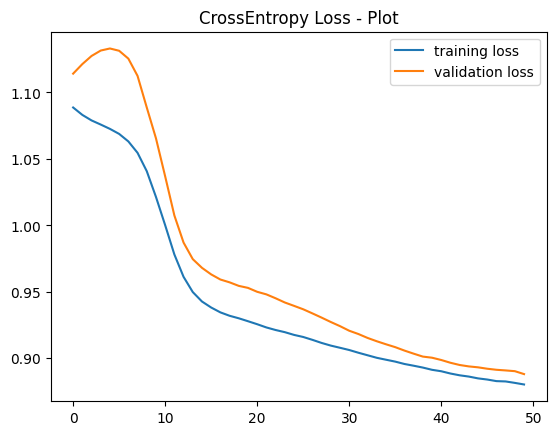

In [ ]:
plt.title('CrossEntropy Loss - Plot')
plt.plot(history["train_loss"], label="training loss")
plt.plot(history["valid_loss"], label="validation loss")
plt.legend()

plt.show()

### Accuracy

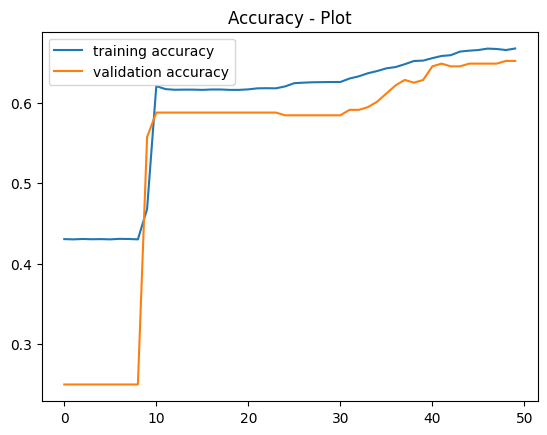

In [ ]:
plt.title("Accuracy - Plot")
plt.plot(history["train_accuracy"], label="training accuracy")
plt.plot(history["valid_accuracy"], label="validation accuracy")
plt.legend()

plt.show()

### F1-score

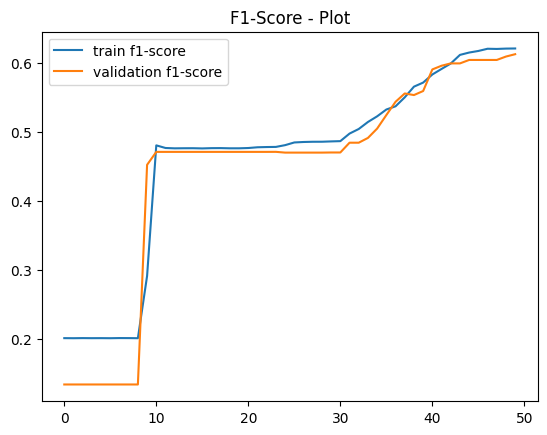

In [ ]:
plt.title("F1-Score - Plot")
plt.plot(history["train_f1_score"], label="train f1-score")
plt.plot(history["valid_f1_score"], label="validation f1-score")
plt.legend()

plt.show()

### Now we save the model

In [ ]:
state_dict = prop_classifier.state_dict()
torch.save(state_dict, "/content/drive/MyDrive/AILovePython_Shared_Folder/models/prop_classifier.tar")